In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import pennylane as qml
from pennylane import numpy as np

In [2]:
# Global variables
WIRES = 4
NODES = WIRES
EDGES = 4
SEED = 76
N_LAYERS = 2
DEV = qml.device("default.qubit", wires=WIRES)
MAX_ITERS = 30
SHOTS = 1000


# GRAPH = nx.gnm_random_graph(NODES, EDGES, seed=SEED)
GRAPH = nx.Graph([(0, 1), (0, 3), (1, 2), (2, 3)])
POSITIONS = nx.spring_layout(GRAPH, seed=SEED)

# Function to set up QAOA cost and mixer Hamiltonians
COST_H, MIXER_H = qml.qaoa.maxcut(GRAPH)
print("Cost Hamiltonian:\n", COST_H)
print("Mixer Hamiltonian:\n", MIXER_H)

Cost Hamiltonian:
   (-2.0) [I0]
+ (0.5) [Z0 Z1]
+ (0.5) [Z0 Z3]
+ (0.5) [Z1 Z2]
+ (0.5) [Z3 Z2]
Mixer Hamiltonian:
   (1) [X0]
+ (1) [X1]
+ (1) [X3]
+ (1) [X2]


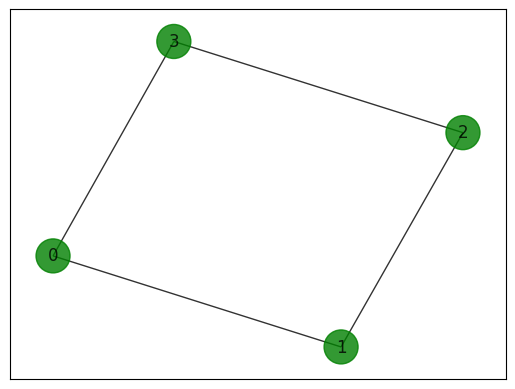

In [3]:
def draw_graph(G, positions):
    """Draws a graph with nodes colored green
    """
    colors = ["green" for node in G.nodes()]
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=positions)
    
draw_graph(GRAPH, positions=POSITIONS)


**Cost Hamiltonian for Maximum Cut**

The given Hamiltonian is:

$H_C = \sum_{(i, j) \in E(G)} Z_i Z_j $

Here, $V(G)$ is the set of vertices of the input graph $G$, and $ E(G) $ is the set of edges of $ G $. $Z_i$ is the Pauli-Z operator applied to the $i$-th vertex.

In [4]:
# Function to set up QAOA cost and mixer Hamiltonians
COST_H, MIXER_H = qml.qaoa.maxcut(GRAPH)
print("Cost Hamiltonian:\n", COST_H)
print("Mixer Hamiltonian:\n", MIXER_H)


Cost Hamiltonian:
   (-2.0) [I0]
+ (0.5) [Z0 Z1]
+ (0.5) [Z0 Z3]
+ (0.5) [Z1 Z2]
+ (0.5) [Z3 Z2]
Mixer Hamiltonian:
   (1) [X0]
+ (1) [X1]
+ (1) [X3]
+ (1) [X2]


In [5]:
# Function to define QAOA layer
def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, COST_H)
    qml.qaoa.mixer_layer(alpha, MIXER_H)

def circuit(params):
    for i in range(WIRES):  # Prepare an equal superposition over all qubits
        qml.Hadamard(wires=i)
    qml.layer(qaoa_layer, N_LAYERS, params[0], params[1])

# Function to define the QAOA cost function
@qml.qnode(device=DEV)
def cost_function(params):
    circuit(params)
    return qml.expval(COST_H)

In [6]:
optimizer = qml.SPSAOptimizer(maxiter=MAX_ITERS)
optimizer = qml.GradientDescentOptimizer(0.07)
list_cost = []


params =  0.01 * np.random.rand(2, N_LAYERS, requires_grad=True)

print("Initial cost:", cost_function(params))

for i in range(MAX_ITERS):
    params, curr_cost = optimizer.step_and_cost(cost_function, params)
    list_cost.append(curr_cost)
    print(f"Iteration: {i}, Cost: {curr_cost}")
    

Initial cost: -1.9994327623619574
Iteration: 0, Cost: -1.9994327623619574
Iteration: 1, Cost: -2.000283960794676
Iteration: 2, Cost: -2.0008611178383062
Iteration: 3, Cost: -2.0027703303458537
Iteration: 4, Cost: -2.009369293650934
Iteration: 5, Cost: -2.0322651719233087
Iteration: 6, Cost: -2.1080952593794953
Iteration: 7, Cost: -2.3176786009663086
Iteration: 8, Cost: -2.6671754223070994
Iteration: 9, Cost: -2.928188852985147
Iteration: 10, Cost: -3.0526601818007375
Iteration: 11, Cost: -3.1025617559412337
Iteration: 12, Cost: -3.12822883582585
Iteration: 13, Cost: -3.148768569699915
Iteration: 14, Cost: -3.168877423301848
Iteration: 15, Cost: -3.189818567638719
Iteration: 16, Cost: -3.212347892802986
Iteration: 17, Cost: -3.23742498786115
Iteration: 18, Cost: -3.266454108318987
Iteration: 19, Cost: -3.3015479174933873
Iteration: 20, Cost: -3.3459248793584004
Iteration: 21, Cost: -3.404399452321135
Iteration: 22, Cost: -3.4833909400413683
Iteration: 23, Cost: -3.588179928188643
Iterat

Text(0, 0.5, 'Cost')

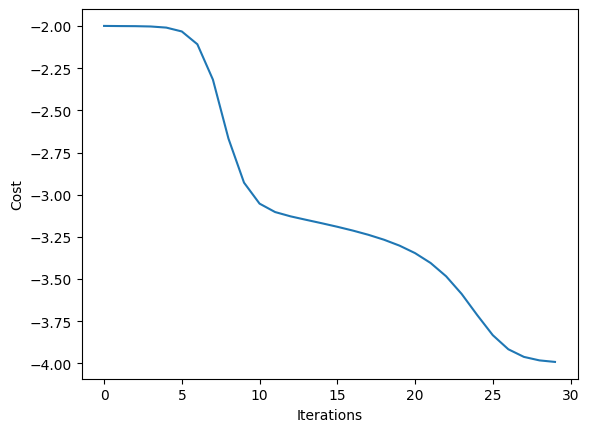

In [7]:
plt.plot(list_cost)
plt.xlabel("Iterations")
plt.ylabel("Cost")

## Investigating the result

How do we know how well the algorithm has performed? To do this, we can sample from the circuit using the optimized parameters. This will give us binary samples that allow us to select which nodes of the graph to use as part of our clique, e.g., either by simply selecting the most common sample or selecting the sample with the lowest corresponding energy.

Let's take some samples and see which ones occur most frequently. To start, we'll create a QNode designed for sampling.

In [8]:
sampling_device = qml.device("braket.local.qubit", wires=WIRES, shots=SHOTS)

@qml.qnode(sampling_device, diff_method="parameter-shift")
def quantum_samples(params):
    circuit(params)
    return qml.probs(wires=range(WIRES))

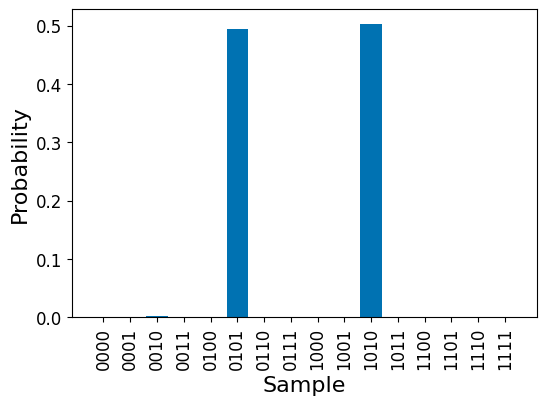

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("seaborn-v0_8-colorblind")
probs = quantum_samples(params)
labels = ["{0:{fill}{length}b}".format(i, fill='0', length=WIRES) for i in range(len(probs))]

plt.bar(range(2**WIRES), probs)
plt.xticks([i for i in range(len(probs))], labels, rotation="vertical", size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=16)
plt.ylabel("Probability", size=16)

fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.show()

Can you see how this is the correct answer?

In [10]:
stop

NameError: name 'stop' is not defined

## Scaling up QAOA for larger graphs with hybrid jobs

We have seen how we can use PennyLane on Braket to solve graph optimization problems with QAOA. However, we have so far restricted to a simple six-node graph and used the local Braket device. Let's now be more ambitious and try to solve an optimization problem on a 18-node graph! We will use [Amazon Braket Hybrid Jobs](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html) to scale up the classical resources, and run the entire algorithm asynchronously. 

We're now set up to train the circuit! Note, if you are training this circuit yourself, you will likely want to increase the number of iterations in the optimization loop and also investigate changing the number of QAOA layers.


We create a hybrid job by annotating our main function with `@hybrid_job`. 
This allows us to choose a target QPU for priority queueing, and additional arguments such as the type of classical instances to use. 
In this example, we use an "ml.c5.xlarge" instance. 

Note that creating hybrid jobs is only supported on Python 3.10. For other versions, you may use [scripts](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html) or a [custom container image](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-byoc.html).

An 18-node graph (which maps to the same number of qubits) definitely puts us in a regime where the local simulator will be slow to execute. As we have discussed in the [parallelization tutorial](../1_Parallelized_optimization_of_quantum_circuits/1_Parallelized_optimization_of_quantum_circuits.ipynb), this slowness will be compounded when it comes to training the circuit, with each optimization step resulting in multiple device executions due to calculation of the gradient. Thankfully, the remote SV1 simulator is highly suited to speeding up gradient calculations through parallelization or adjoint differentiation. We now show that this makes training the circuit for QAOA solvable within a reasonable time.

Yuo can load a new device as follows 

```device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1" ``` # alternatively use the device ARN
We now just need to set up the QAOA circuit and optimization problem in the same way as before. However, we will switch to a new optimization problem to keep things interesting: aiming to solve maximum cut, with the objective of partitioning the graph's nodes into two groups so that the greatest number of edges are shared between the groups (see the image below). This problem is NP-hard, so we expect it to be tough as we increase the number of graph nodes.

In [ ]:
import time
from braket.tracking import Tracker
from braket.jobs import hybrid_job, InstanceConfig
from braket.jobs.metrics import log_metric

large_instance = InstanceConfig(instanceType="ml.c5.xlarge")

from braket.devices import Devices
device_arn = Devices.Amazon.SV1

# Global variables
WIRES = 18
NODES = WIRES
EDGES = 60
SEED = 1967
N_LAYERS = 2
DEV = qml.device("default.qubit", wires=WIRES)
MAX_ITERS = 50
SHOTS = 1000


GRAPH = nx.gnm_random_graph(NODES, EDGES, seed=SEED)
# GRAPH = nx.Graph([(0, 1), (0, 3), (1, 2), (2, 3)])
POSITIONS = nx.spring_layout(GRAPH, seed=SEED)

# Function to set up QAOA cost and mixer Hamiltonians
COST_H, MIXER_H = qml.qaoa.maxcut(GRAPH)
print("Cost Hamiltonian:\n", COST_H)
print("Mixer Hamiltonian:\n", MIXER_H)


@hybrid_job(device="local:pennylane/lightning.qubit", instance_config=large_instance)
def qaoa_training(iterations, n_layers=2):
    task_tracker = Tracker().start()  # track Braket tasks costs

    dev = qml.device("lightning.qubit", wires=WIRES)

    @qml.qnode(dev)
    def cost_function(params, **kwargs):
        for i in range(WIRES):  # Prepare an equal superposition over all qubits
            qml.Hadamard(wires=i)

        qml.layer(qaoa_layer, n_layers, params[0], params[1])
        return qml.expval(COST_H)

    params = 0.01 * np.random.uniform(size=[2, n_layers])

    for i in range(iterations):
        optimizer = qml.SPSAOptimizer(maxiter=MAX_ITERS)
        params, cost = optimizer.step_and_cost(cost_function, params)

        # Record the value of the cost function with each iteration
        log_metric(metric_name="cost", value=cost, iteration_number=i)

        # Additionally, keep track of cost in USD for Braket tasks
        braket_task_cost = float(
            task_tracker.qpu_tasks_cost() + task_tracker.simulator_tasks_cost()
        )
        log_metric(metric_name="braket_cost", value=braket_task_cost, iteration_number=i)

    return {
        "parameters": params,
        "final_cost": cost_function(params),
        "braket_tasks_cost (USD)": task_tracker.qpu_tasks_cost() + task_tracker.simulator_tasks_cost(),
    }

Cost Hamiltonian:
   (-2.0) [I0]
+ (0.5) [Z0 Z1]
+ (0.5) [Z0 Z3]
+ (0.5) [Z1 Z2]
+ (0.5) [Z3 Z2]
Mixer Hamiltonian:
   (1) [X0]
+ (1) [X1]
+ (1) [X3]
+ (1) [X2]


In [ ]:
job = qaoa_training(iterations=MAX_ITERS, n_layers=2)
print(job)

AwsQuantumJob('arn':'arn:aws:braket:us-east-1:384157512613:job/qaoa-training-1703600672546')


The hybrid job will be scheduled to run and will appear in the "QUEUED" state. 
If the target is a QPU, the hybrid job will be queued with other hybrid jobs. 
If the target device is not a QPU, the hybrid job should start immediately. 

Note that since the algorithm code is run in a containerized environment, it takes approximately 1 minute to start running your algorithm. 

Once the state is "COMPLETED", we retrieve the results with 

In [ ]:
%%time

job.result()

CPU times: user 287 ms, sys: 20.5 ms, total: 308 ms
Wall time: 2min 42s


{'parameters': tensor([[ 0.79466423,  0.93408002],
         [-0.477812  , -0.36703993]], requires_grad=True),
 'final_cost': array(-3.78113132),
 'braket_tasks_cost (USD)': Decimal('0')}

The results included the three values from the return statement of our function.

Additionally, we can retrieve the metrics recorded during the training with:

In [ ]:
import pandas as pd

metrics = job.metrics()
df = pd.DataFrame(metrics)
df = df.groupby("iteration_number").sum().reset_index()
df

,iteration_number,timestamp,cost,braket_cost
0,0.0,3.407202e+09,-1.999687,0.0
1,1.0,3.407202e+09,-1.999897,0.0
2,2.0,3.407202e+09,-1.999946,0.0
3,3.0,3.407202e+09,-1.999950,0.0
4,4.0,3.407202e+09,-2.000261,0.0
5,5.0,3.407202e+09,-2.000402,0.0
6,6.0,3.407202e+09,-2.000400,0.0
7,7.0,3.407202e+09,-2.000523,0.0
8,8.0,3.407202e+09,-2.000526,0.0
9,9.0,3.407202e+09,-2.000505,0.0


The metrics are plotted below. 

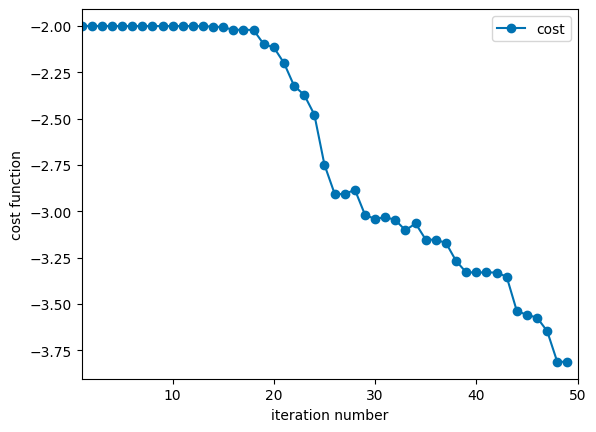

In [ ]:
# Plotting the convergence of the loss function metric
import matplotlib.pyplot as plt

%matplotlib inline

df.sort_values(by=["iteration_number"]).plot(x="iteration_number", y="cost", marker="o")
plt.xlim(1, MAX_ITERS)
plt.xlabel("iteration number")
plt.ylabel("cost function");

In [ ]:
job_cost = job.result()["braket_tasks_cost (USD)"]

print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2)."
)
print(f"Estimated cost to run this example: {job_cost :.3f} USD")

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.000 USD
